# Exploratory data analysis of the data from Meningioma patients


---

## 0. Environmental setup

First, we load the required libraries and define functions, that we will use later on for the analyses.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import sys
import cv2 as cv

sys.path.append("../../../../..")
from src.utils.notebooks.eda import *

seed = 1234
random.seed(1234)
np.random.seed(1234)

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [4]:
hv_root_data_dir = "../../../../../data/control/proteins"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [5]:
hv_data = read_in_protein_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 10/10 [00:00<00:00, 37.12it/s]


<IPython.core.display.Javascript object>

In [92]:
patients = ["p27", "p33", "p37", "p38", "p42"]

tp1_root_data_dir = "../../../../../data/meningioma/patients/proteins/timepoint_1/"
tp2_root_data_dir = "../../../../../data/meningioma/patients/proteins/timepoint_2/"
tp3_root_data_dir = "../../../../../data/meningioma/patients/proteins/timepoint_3/"

tp1_features = read_in_protein_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=patients,
)

tp2_features = read_in_protein_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=patients,
)

tp3_features = read_in_protein_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=patients,
)

pt_data = tp1_features.append(tp2_features).append(tp3_features)
pt_data["id"] = pt_data["sample"] + pt_data["timepoint"]

Load data: 100%|██████████| 5/5 [00:00<00:00, 33.28it/s]


<IPython.core.display.Javascript object>

In [101]:
counts = Counter(pt_data.loc[:, "id"])
{k: counts[k] for k in sorted(list(counts.keys()))}

{'p271': 351,
 'p272': 351,
 'p273': 351,
 'p331': 351,
 'p332': 351,
 'p333': 351,
 'p371': 351,
 'p372': 351,
 'p373': 351,
 'p381': 351,
 'p382': 351,
 'p383': 351,
 'p421': 351,
 'p422': 351,
 'p423': 351}

<IPython.core.display.Javascript object>

In [97]:
len(pt_data)

7294

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [98]:
np.random.seed(seed)
n_samples = np.min([len(hv_data)] + list(Counter(pt_data.id).values()))

hv_data = hv_data.iloc[
    np.random.choice(
        list(range(len(hv_data))),
        replace=False,
        size=n_samples * len(np.unique(pt_data.loc[:, "sample"])),
    )
]
hv_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_lamin_3d_int,min_lamin_3d_int,max_lamin_3d_int,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int
count,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,...,1755.000000,1755.0,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,4.400570,58.682051,72.376068,0.813410,24.667397,36.824568,31.769513,31.539060,24.769013,29.447720,...,1783.636597,0.0,16996.145299,1783.636597,1980.623575,385.412678,2570.133191,1078.668376,10.583573,2.666957
std,2.866012,5.800689,6.016880,0.078396,3.746357,3.246460,2.429202,2.337118,3.771469,2.662569,...,3991.321282,0.0,15661.546206,3991.321282,3115.078599,1504.028040,6278.171275,3305.609087,6.611626,0.787043
min,1.000000,28.000000,38.000000,0.401869,0.365230,18.751232,15.292438,13.878844,0.805253,10.900053,...,64.243603,0.0,4462.000000,64.243603,219.386111,0.000000,57.000000,0.000000,-1.624932,-0.168657
25%,2.000000,55.000000,69.000000,0.767123,22.657992,34.813584,30.461309,30.296984,22.669985,28.024154,...,311.669956,0.0,7650.500000,311.669956,628.581324,0.000000,193.000000,41.500000,6.532993,2.184162
50%,4.000000,59.000000,72.000000,0.826667,25.125112,36.493418,31.742853,31.591108,25.149235,29.613436,...,466.291296,0.0,9712.000000,466.291296,806.062579,0.000000,779.000000,73.000000,10.031609,2.683321
75%,6.000000,63.000000,75.000000,0.871429,27.240603,38.383837,33.165574,32.828346,27.325416,31.167448,...,1244.101126,0.0,19707.000000,1244.101126,1838.609724,5.500000,2020.125000,326.500000,13.775409,3.178116
max,22.000000,76.000000,116.000000,0.970588,33.045294,59.245408,40.720965,39.017151,36.742734,36.434908,...,40549.326232,0.0,65535.000000,40549.326232,23595.542877,19961.750000,65535.000000,41026.500000,95.266985,8.279597


<IPython.core.display.Javascript object>

In [99]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(pt_data)))).reshape(-1, 1)
sample_idc, _ = sampler.fit_resample(idc, np.array(pt_data.loc[:, "id"]))
pt_data = pt_data.iloc[sample_idc[:, 0]]
pt_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,rel_lamin_3d_int,min_lamin_3d_int,max_lamin_3d_int,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int
count,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,...,5265.000000,5265.0,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000,5265.000000
mean,7.220323,58.783096,74.633238,0.792663,24.344650,38.122431,32.151658,31.951873,24.418303,29.484591,...,206.961618,0.0,7182.003419,206.961618,449.580685,0.697578,222.360494,34.304368,51.292201,5.704890
std,4.597112,5.593301,7.350392,0.087037,4.188714,4.043797,2.358535,2.288664,4.239982,2.515349,...,245.262740,0.0,2764.599616,245.262740,328.817276,7.288391,376.785499,114.913495,33.436953,1.866346
min,1.000000,19.000000,44.000000,0.340278,0.344030,22.441449,16.541540,15.489604,0.344030,11.484462,...,53.535677,0.0,2893.000000,53.535677,145.606520,0.000000,54.000000,0.000000,2.846218,1.495197
25%,3.000000,55.000000,70.000000,0.740260,22.283057,35.578607,30.687450,30.551899,22.308366,27.956183,...,91.996241,0.0,5357.000000,91.996241,257.421943,0.000000,96.000000,0.000000,26.034636,4.388851
50%,7.000000,59.000000,73.000000,0.802632,24.959521,37.376189,32.017869,31.820914,25.020065,29.527577,...,122.438530,0.0,6262.000000,122.438530,340.855749,0.000000,110.000000,12.000000,44.190775,5.675783
75%,10.000000,62.000000,78.000000,0.857143,27.103462,39.725903,33.457382,33.205583,27.154607,31.070851,...,192.779971,0.0,7828.000000,192.779971,482.504374,0.000000,136.000000,28.000000,72.077287,7.126929
max,25.000000,78.000000,144.000000,0.983333,34.873592,78.919429,41.889384,41.351502,37.866221,37.651337,...,2695.910814,0.0,31893.000000,2695.910814,2949.627764,219.750000,3904.250000,1703.000000,263.313173,11.960307


<IPython.core.display.Javascript object>

Finally, we combine the undersampled data.

In [24]:
data = hv_data.append(pt_data)

<IPython.core.display.Javascript object>

In [25]:
Counter(data.timepoint)

Counter({'ctrl': 1755, '1': 1755, '2': 1755, '3': 1755})

<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features, as well as those samples that were flagged for not passing our quality checks.

In [26]:
data = preprocess_data(data)

Nuclei that did not pass the quality check: 429/7020. Remaining: 6591.
Removed 16 constant or features with missing values. Remaining: 264.
Removed additional 6 features. Remaining: 258.


<IPython.core.display.Javascript object>

In [27]:
data.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,mean_lamin_3d_int,std_lamin_3d_int,q25_lamin_3d_int,q75_lamin_3d_int,median_lamin_3d_int,kurtosis_lamin_3d_int,skewness_lamin_3d_int,sample,timepoint,id
HV3_PBMC_Dapi_gH2AX__lamin_29_7_21_2X_16bit_3_1,58.0,68.0,0.852941,22.220440,34.363284,31.292367,30.437553,22.220440,28.695235,32.314863,...,2318.305892,2775.521081,136.00,3297.0,1231.0,4.630926,1.908308,hv3,ctrl,hv3ctrl
HV7_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_23_0,56.0,80.0,0.700000,25.028764,40.489425,33.480038,32.833952,25.028764,28.724090,36.644340,...,8857.988591,8422.829756,2730.50,12427.5,6222.0,4.122399,1.754370,hv7,ctrl,hv7ctrl
HV10_PBMC_Dapi_gH2AX__lamin_16_8_21_2X_16bit_6_4,53.0,70.0,0.757143,23.058245,35.965565,29.611265,29.786902,23.058245,27.593957,32.604554,...,180.288747,427.691248,0.00,136.0,30.0,25.617612,4.306375,hv10,ctrl,hv10ctrl
HV7_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_25_0,66.0,76.0,0.868421,29.220308,38.720095,34.699182,34.351013,29.220308,32.886851,35.737954,...,6515.254839,4974.385068,2653.75,9202.0,5471.5,1.563053,1.147593,hv7,ctrl,hv7ctrl
HV1_PBMC_Dapi_gH2AX__lamin_13_8_21_2X_16bit_35_1,59.0,69.0,0.855072,23.391059,35.236845,31.409377,31.125982,23.391059,30.450730,32.463775,...,448.077360,813.511640,0.00,430.0,85.0,13.021892,2.980856,hv1,ctrl,hv1ctrl


<IPython.core.display.Javascript object>

In [57]:
features = data._get_numeric_data()
sample_labels = data.loc[:, "sample"]
tp_labels = data.loc[:, "timepoint"]

<IPython.core.display.Javascript object>

Next, we will remove a number of DNA intensity features that are related to absolute intensity values as the gain was adapted for each imaged sample. Thus, absolute intensity values are hardly comparable. We also remove any features related to the gH2AX intensity for now as we have seen significant batch effects between the control imaging setup and the one used for the patient samples.

In [58]:
features = features.loc[:, ~features.columns.str.contains("dna_3d_int")]
features = features.loc[:, ~features.columns.str.contains("dna_2d_int")]
features = features.loc[:, ~features.columns.str.contains("gh2ax_3d_int")]
features = features.loc[:, ~features.columns.str.contains("gh2ax_2d_int")]

<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [59]:
features = remove_correlated_features(features, threshold=0.8)

Removed 167/225 features with a Pearson correlation above 0.8. Remaining: 58


<IPython.core.display.Javascript object>

There are 58 features that remain which have a correlation of less than 0.8 to any other feature.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [60]:
features_sc = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns,
)
features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,std_curvature,npolarity_changes,max_posi_curv,...,equivalent_diameter.1,extent,solidity.1,rel_hc_volume,rdp_1,gh2ax_foci_count,rel_lamin_2d_int,kurtosis_lamin_2d_int,skewness_lamin_2d_int,kurtosis_lamin_3d_int
count,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,...,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6.591000e+03,6591.000000,6.591000e+03,6.591000e+03,6.591000e+03
mean,6.382056e-16,1.030616e-15,-4.182834e-16,-6.037080e-17,1.884431e-15,8.624400e-18,2.112978e-15,2.759808e-16,2.587320e-17,-5.347128e-16,...,-1.060801e-15,-1.293660e-16,4.398444e-16,1.699007e-15,-6.791715e-17,-6.899520e-17,0.000000,-8.624400e-17,-1.379904e-16,6.899520e-17
std,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,...,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076,1.000076e+00,1.000076e+00,1.000076e+00
min,-7.580129e+00,-3.436242e+00,-5.457404e+00,-6.383217e+00,-6.462409e+00,-1.356213e+00,-9.692701e+00,-2.395995e+00,-2.694626e+00,-1.810834e+00,...,-1.039690e+01,-5.912214e+00,-8.076738e+00,-3.832286e+00,-9.382812e-01,-2.711314e+00,-0.384352,-8.359124e-01,-3.695042e+01,-1.257359e+00
25%,-7.570294e-01,-6.153596e-01,-5.964910e-01,-5.227496e-01,-6.770424e-01,-6.531749e-01,-5.448764e-01,-7.253419e-01,-6.678908e-01,-6.010487e-01,...,-6.877150e-01,-5.656122e-01,-4.145914e-01,-7.180236e-01,-7.505640e-01,-6.030348e-01,-0.307354,-2.538332e-01,-4.993991e-01,-8.362905e-01
50%,1.092726e-03,-1.699571e-01,1.342579e-01,1.287108e-01,-7.656336e-02,-2.507974e-01,1.103478e-01,-1.196540e-01,-2.786924e-02,-1.962445e-01,...,-4.316074e-02,1.016778e-01,2.493725e-01,7.156556e-02,-3.095099e-01,-1.069691e-01,-0.255879,-1.145741e-01,-1.421316e-01,-2.027383e-01
75%,7.592149e-01,4.239129e-01,7.442949e-01,6.781268e-01,5.834637e-01,3.463885e-01,6.604568e-01,6.341204e-01,6.121523e-01,4.691624e-01,...,5.643889e-01,6.767506e-01,6.724466e-01,8.073012e-01,3.964945e-01,3.890966e-01,-0.059067,1.193825e-01,3.831131e-01,5.325829e-01
max,3.602173e+00,1.037124e+01,2.171758e+00,2.694268e+00,4.627888e+00,1.890705e+01,2.518157e+00,5.918397e+00,8.505751e+00,1.476227e+01,...,4.566537e+00,2.892859e+00,1.802781e+00,2.776430e+00,7.705518e+00,6.713935e+00,12.986952,6.976091e+01,9.421453e+00,6.461930e+00


<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [61]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])

<IPython.core.display.Javascript object>

Next, we will plot the TSNE embeddings for each time point individually including the controls.

#### Time point 1 (before treatement)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


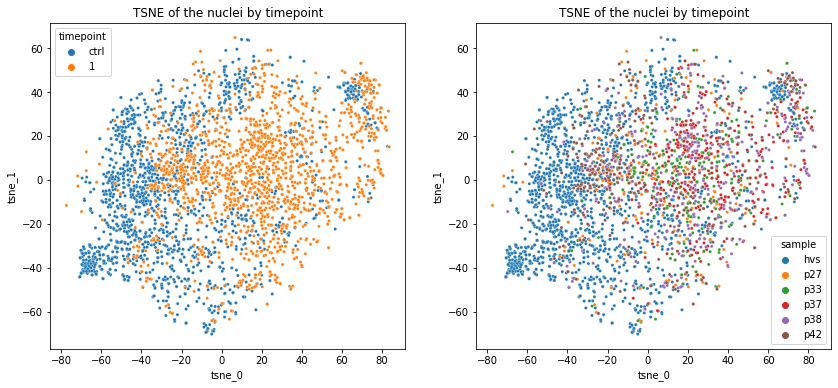

<IPython.core.display.Javascript object>

In [62]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "1"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

#### Timpoint 2 (during treatment)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


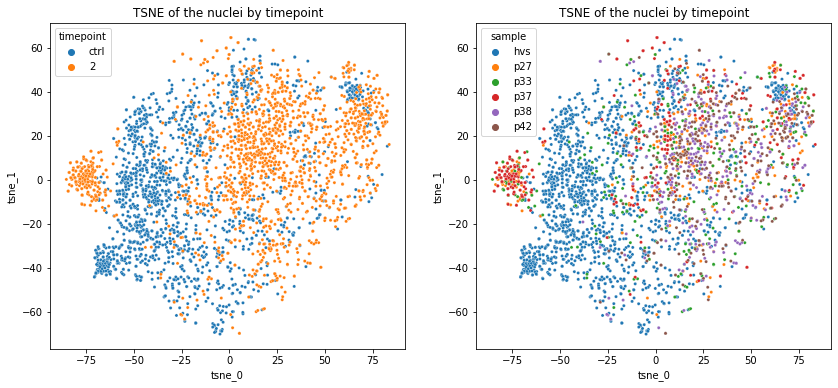

<IPython.core.display.Javascript object>

In [63]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "2"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs.loc[:, "timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

There appears an outlier distribution of patient samples. To better understand that cluster, we will cluster the TSNE embeddings into using hierarchical clustering and then characterize the cluster.

In [64]:
from sklearn.cluster import AgglomerativeClustering

cluster_labels = AgglomerativeClustering(n_clusters=2).fit_predict(
    tmp_embs.loc[tmp_embs.timepoint != "ctrl", ["tsne_0", "tsne_1"]]
)

<IPython.core.display.Javascript object>

In [65]:
len(tmp_embs.loc[tmp_embs.timepoint != "ctrl"].loc[cluster_labels == 1])

205

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='tsne_0', ylabel='tsne_1'>

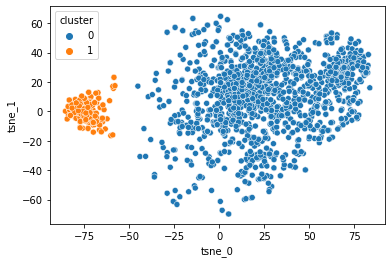

<IPython.core.display.Javascript object>

In [66]:
pt_tmp_embs = tmp_embs.loc[tmp_embs.timepoint != "ctrl"].copy()
pt_tmp_embs["cluster"] = cluster_labels.astype("str")
sns.scatterplot(data=pt_tmp_embs, x="tsne_0", y="tsne_1", hue="cluster")

In [67]:
Counter(pt_tmp_embs.loc[pt_tmp_embs.cluster == "1", "sample"])

Counter({'p27': 62, 'p33': 31, 'p37': 112})

<IPython.core.display.Javascript object>

In [68]:
sorted(list(pt_tmp_embs.loc[pt_tmp_embs.cluster == "1"].index))

['TileScan 1_Position 11_0_3',
 'TileScan 1_Position 11_2_4',
 'TileScan 1_Position 11_3_6',
 'TileScan 1_Position 11_4_5',
 'TileScan 1_Position 11_5_5',
 'TileScan 1_Position 12_1_6',
 'TileScan 1_Position 12_2_6',
 'TileScan 1_Position 12_5_5',
 'TileScan 1_Position 13_3_5',
 'TileScan 1_Position 14_0_5',
 'TileScan 1_Position 14_3_4',
 'TileScan 1_Position 14_5_6',
 'TileScan 1_Position 15_1_5',
 'TileScan 1_Position 15_2_5',
 'TileScan 1_Position 18_1_5',
 'TileScan 1_Position 18_7_5',
 'TileScan 1_Position 20_0_3',
 'TileScan 1_Position 20_4_2',
 'TileScan 1_Position 21_0_3',
 'TileScan 1_Position 21_1_4',
 'TileScan 1_Position 22_0_4',
 'TileScan 1_Position 22_3_3',
 'TileScan 1_Position 22_5_5',
 'TileScan 1_Position 23_1_4',
 'TileScan 1_Position 23_2_2',
 'TileScan 1_Position 24_6_6',
 'TileScan 1_Position 25_9_2',
 'TileScan 1_Position 26_3_4',
 'TileScan 1_Position 26_5_2',
 'TileScan 1_Position 28_2_3',
 'TileScan 1_Position 2_0_2',
 'TileScan 1_Position 2_4_1',
 'TileScan

<IPython.core.display.Javascript object>

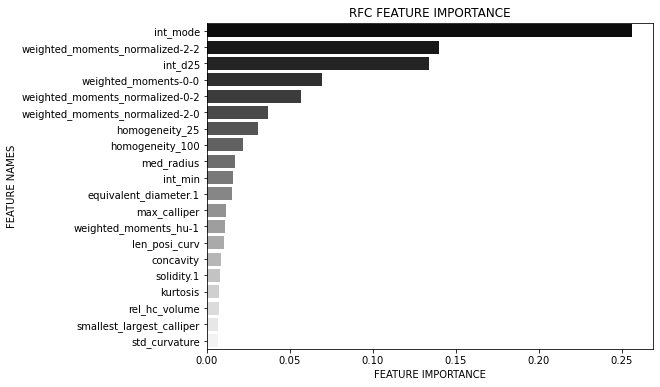

<IPython.core.display.Javascript object>

In [69]:
rfc_pt_tmp = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=seed)
rfc_pt_tmp = rfc_pt_tmp.fit(features_sc.loc[pt_tmp_embs.index], cluster_labels)
plot_feature_importance(rfc_pt_tmp.feature_importances_, features_sc.columns, "RFC ")

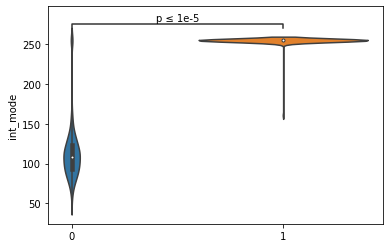

<IPython.core.display.Javascript object>

In [70]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.violinplot(
    x=cluster_labels.astype("str"), y=data.loc[pt_tmp_embs.index, "int_mode"], ax=ax
)
add_stat_annotation(
    ax,
    x=cluster_labels.astype("str"),
    y=data.loc[pt_tmp_embs.index, "int_mode"],
    box_pairs=[
        ("0", "1"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

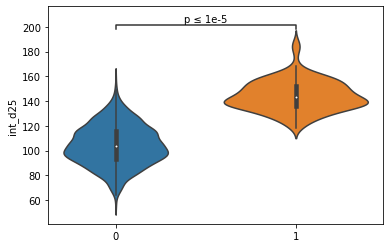

<IPython.core.display.Javascript object>

In [71]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.violinplot(
    x=cluster_labels.astype("str"), y=data.loc[pt_tmp_embs.index, "int_d25"], ax=ax
)
add_stat_annotation(
    ax,
    x=cluster_labels.astype("str"),
    y=data.loc[pt_tmp_embs.index, "int_d25"],
    box_pairs=[
        ("0", "1"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

The analysis above indicates that the given cell that cluster apart are artifacts that should be excluded from the analysis.

Thus we drop those samples.

In [72]:
features_sc = features_sc.drop(
    list(pt_tmp_embs.loc[pt_tmp_embs.index == 1].index), axis=0
)
sample_labels = data.loc[features_sc.index, "sample"]
tp_labels = data.loc[features_sc.index, "timepoint"]

<IPython.core.display.Javascript object>

#### Timpoint 3 (post final treatment)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


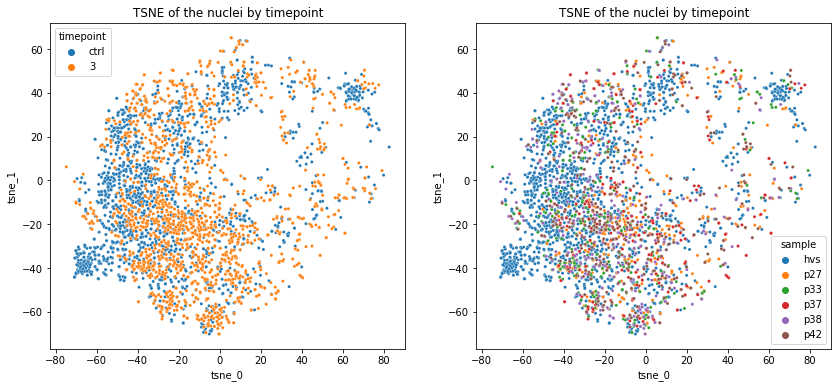

<IPython.core.display.Javascript object>

In [74]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "3"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs.loc[:, "timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

The plots above show the heterogeneous response of the two patients to the treatments although both appear to seem to approach the healthy phenotype to some degree after treatment. This is however more prominent for P15 who has undergone prior treatment. Thus, the effect could be also due to the recovery from the preceeding treatment.

---

## 4. Separability of the time points

Next, we will look more into the differences of the PBMC phenotypes at the different time points of the treatment in comparison to the healthy controls. To this end, we will train a RandomForest classifier model on distinguishing between the different data conditions.

To this end, we perform a 10-fold Stratified cross-validation approach and look at the average confusion matrix of the individual folds.

In [134]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=seed)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc,
    n_folds=10,
    features=features_sc,
    labels=tp_labels,
)

<IPython.core.display.Javascript object>

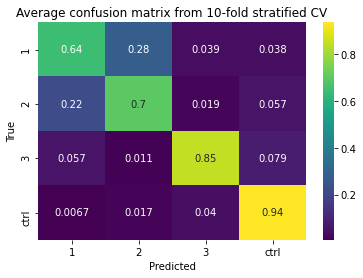

<IPython.core.display.Javascript object>

In [135]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(10))
plt.show()

The confusion matrix further emphasizes the previous statements. We see that overall each time point is relatively distinct from the other and from the negative control. However, for the later time points (intermediate and post-treatment) the phenotypes of the models become more heterogenous some showing features more similar to the healthy control especially for the intermediate time point that is visible. Whereas, for the later we see a relative uniform distribution of the predicted classes for the missclassified samples.

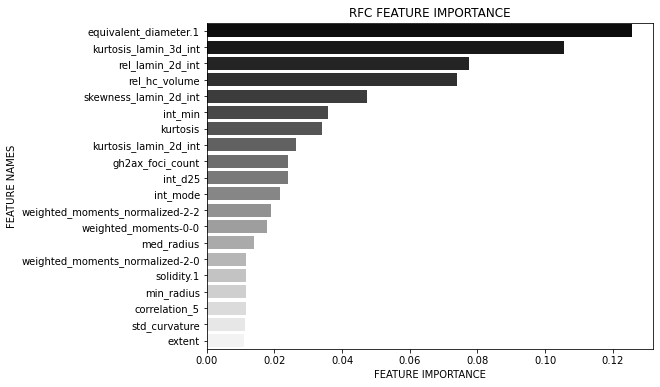

<IPython.core.display.Javascript object>

In [136]:
rfc = rfc.fit(
    features_sc,
    tp_labels,
)
plot_feature_importance(
    rfc.feature_importances_,
    features_sc.columns,
    "RFC ",
)

When we look at the features that got the highest importance we see that many of these are related to intensity features of the protein and 2D projected DAPI channel. Additionally some structural features like the equivalent diameter and the curvature are changing.

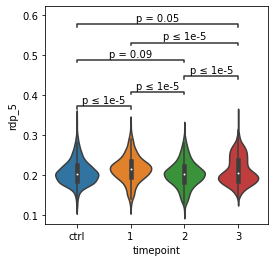

<IPython.core.display.Javascript object>

In [155]:
fig, ax = plt.subplots(figsize=[4, 4])
sns.violinplot(
    data=data,
    x="timepoint",
    y="rdp_5",
    ax=ax,
)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="rdp_5",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

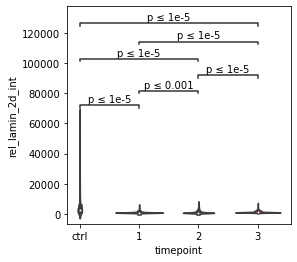

<IPython.core.display.Javascript object>

In [158]:
fig, ax = plt.subplots(figsize=[4, 4])
sns.violinplot(data=data, x="timepoint", y="rel_lamin_2d_int", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="rel_lamin_2d_int",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

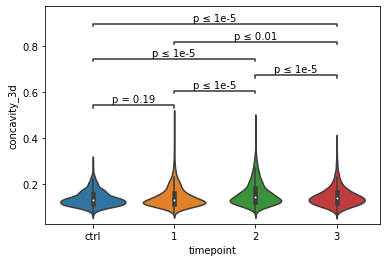

<IPython.core.display.Javascript object>

In [140]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.violinplot(data=data, x="timepoint", y="concavity_3d", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="concavity_3d",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

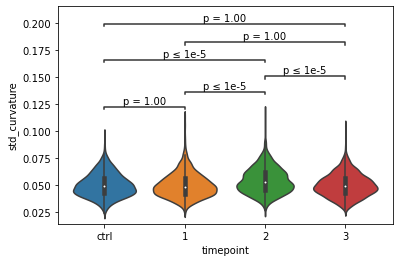

<IPython.core.display.Javascript object>

In [141]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.violinplot(data=data, x="timepoint", y="std_curvature", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="std_curvature",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

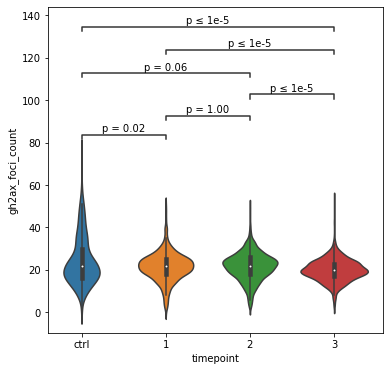

<IPython.core.display.Javascript object>

In [142]:
fig, ax = plt.subplots(figsize=[6, 6])
sns.violinplot(data=data, x="timepoint", y="gh2ax_foci_count", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="gh2ax_foci_count",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

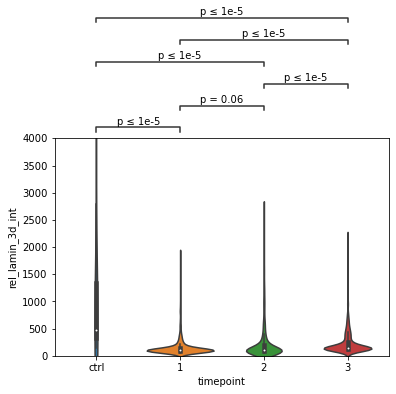

<IPython.core.display.Javascript object>

In [143]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylim([0, 4000])
sns.violinplot(data=data, x="timepoint", y="rel_lamin_3d_int", ax=ax)
add_stat_annotation(
    ax,
    data=data,
    x="timepoint",
    y="rel_lamin_3d_int",
    box_pairs=[
        ("ctrl", "1"),
        ("ctrl", "2"),
        ("ctrl", "3"),
        ("1", "2"),
        ("1", "3"),
        ("2", "3"),
    ],
    test="Mann-Whitney",
    loc="outside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

Let us also test the differences that we observe between the samples.

In [144]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=seed)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc, n_folds=10, features=features_sc, labels=sample_labels
)

<IPython.core.display.Javascript object>

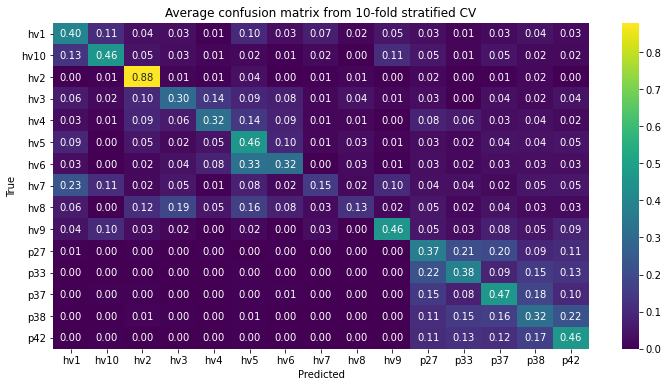

<IPython.core.display.Javascript object>

In [150]:
fig, ax = plt.subplots(figsize=[12, 6])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax, fmt=".2f")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(10))
plt.show()